### Import Libraries

In [1]:
from sqlalchemy import create_engine, text
import sys
import calendar

import pandas as pd
import pandas.api.types as ptypes
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.ticker import FuncFormatter, PercentFormatter
def millions_formatter(x, pos):
    return f'{x / 1e6:.1f}M'
def thousands_formatter(x, pos):
    return f'{x / 1e3:.1f}K'

### Import data from local postgres database

In [2]:
# --- 1. Database Configuration ---
# Store configuration in a dictionary for clarity.
# IMPORTANT: Replace placeholder values with your actual credentials.
# Consider using environment variables or a config file for production/shared code.
DB_CONFIG = {
    "type": "postgresql",
    "driver": "psycopg2",
    "user": "postgres", 
    "pass": "password", 
    "host": "localhost", 
    "port": "5432", 
    "name": "contoso_100k" 
}

# --- 2. Database Connection Function ---
def create_db_engine(config):
    """
    Creates a SQLAlchemy engine for the database connection.

    Args:
        config (dict): Dictionary containing database connection parameters.

    Returns:
        sqlalchemy.engine.Engine or None: The created engine, or None if connection fails.
    """
    try:
        # Construct the database connection URL
        connection_url = (
            f"{config['type']}+{config['driver']}://"
            f"{config['user']}:{config['pass']}@"
            f"{config['host']}:{config['port']}/{config['name']}"
        )
        engine = create_engine(connection_url)
        # Test connection briefly
        with engine.connect() as _:
            pass # Connection successful if this doesn't raise an error
        print("Database connection established successfully.")
        return engine
    except Exception as e:
        print(f"Error connecting to the database: {e}")
        return None

# --- 3. Table Loading Function ---
def load_dataframes_from_db(engine, table_names):
    """
    Loads specified tables from the database into a dictionary of pandas DataFrames,
    checking row counts beforehand.

    Args:
        engine (sqlalchemy.engine.Engine): The SQLAlchemy engine to use for connection.
        table_names (list): A list of table names to load.

    Returns:
        dict: A dictionary where keys are table names (e.g., 'sales')
              and values are the corresponding pandas DataFrames. Returns an empty
              dictionary if errors occur during loading.
    """
    dataframes = {}
    print("\n--- Loading Tables into DataFrames ---")

    with engine.connect() as connection:
        for table in table_names:
            print(f"\nProcessing table: '{table}'")
            try:
                # Step A: Check row count (Good practice for documentation and large datasets)
                count_query = text(f"SELECT COUNT(*) FROM {table};")
                count_result = connection.execute(count_query)
                row_count = count_result.scalar()
                print(f"-> Found {row_count:,} rows.") # Format count with comma

                # Step B: Load table into DataFrame
                print(f"-> Loading '{table}' into DataFrame...")
                df = pd.read_sql_table(table, connection) # Use the existing connection
                dataframes[table] = df # Use table name as key
                print(f"-> Successfully loaded '{table}'. Shape: {df.shape}")

                # Optional Step C: Display memory usage for larger tables if needed
                # if table == 'sales' or table == 'customer':
                #    print("   Memory Usage:")
                #    df.info(memory_usage='deep', verbose=False) # Concise info

            except Exception as e:
                print(f"ERROR loading table '{table}': {e}")
                print(f"Skipping table '{table}'.")
                # Decide if you want to stop entirely or just skip the table
                # If critical tables fail, you might want `return {}` here

    return dataframes

# --- 4. Main Execution ---
print("--- Contoso Data Loading ---")

# Create the database engine
db_engine = create_db_engine(DB_CONFIG)

# Proceed only if the connection was successful
if db_engine:
    # Define the tables we want to load
    tables_to_load = ["currencyexchange", "customer", "product", "sales", "store", "date"]

    # Load the tables into dataframes
    loaded_dfs = load_dataframes_from_db(db_engine, tables_to_load)

    if loaded_dfs:
        print("\n--- Data Loading Summary ---")
        print("Successfully loaded DataFrames for:")
        for name, df in loaded_dfs.items():
            print(f"- {name}: {df.shape}")

        # You can now access your dataframes using the dictionary keys, e.g.:
        # sales_df = loaded_dfs['sales']
        # customer_df = loaded_dfs['customer']
        # product_df = loaded_dfs['product']
        # store_df = loaded_dfs['store']
        # currency_df = loaded_dfs['currencyexchange']
        # date_df = loaded_dfs['date']
        # print("\nExample: First 5 rows of 'customer' data:")
        # if 'customer' in loaded_dfs:
        #     print(loaded_dfs['customer'].head())

        # Reminder about next steps
        print("\nNext Steps: Data cleaning, EDA, and analysis.")
        print("Consider optimizing DataFrame memory usage with .astype() if needed.")

    else:
        print("\nNo DataFrames were loaded due to errors.")

    # Dispose the engine connection pool when completely done
    db_engine.dispose()
    print("\nDatabase connection closed.")

else:
    print("\nScript aborted due to database connection failure.")
    sys.exit(1) # Exit with an error code

--- Contoso Data Loading ---
Database connection established successfully.

--- Loading Tables into DataFrames ---

Processing table: 'currencyexchange'
-> Found 91,325 rows.
-> Loading 'currencyexchange' into DataFrame...
-> Successfully loaded 'currencyexchange'. Shape: (91325, 4)

Processing table: 'customer'
-> Found 104,990 rows.
-> Loading 'customer' into DataFrame...
-> Successfully loaded 'customer'. Shape: (104990, 24)

Processing table: 'product'
-> Found 2,517 rows.
-> Loading 'product' into DataFrame...
-> Successfully loaded 'product'. Shape: (2517, 14)

Processing table: 'sales'
-> Found 199,873 rows.
-> Loading 'sales' into DataFrame...
-> Successfully loaded 'sales'. Shape: (199873, 13)

Processing table: 'store'
-> Found 74 rows.
-> Loading 'store' into DataFrame...
-> Successfully loaded 'store'. Shape: (74, 11)

Processing table: 'date'
-> Found 3,653 rows.
-> Loading 'date' into DataFrame...
-> Successfully loaded 'date'. Shape: (3653, 17)

--- Data Loading Summary 

### Create a master dataframe

In [3]:
# --- Step 1: Set Indices on Dimension Tables (Product, Customer, Store) ---

print("--- Step 1: Setting Indices on Dimension Tables ---")

dimension_tables = ['product', 'customer', 'store']
key_columns = {'product': 'productkey', 'customer': 'customerkey', 'store': 'storekey'}

indices_set = {}

try:
    for table_key in dimension_tables:
        if table_key in loaded_dfs:
            df = loaded_dfs[table_key]
            key_col = key_columns[table_key]

            if key_col in df.columns:
                # Check uniqueness
                if df[key_col].is_unique:
                    df.set_index(key_col, inplace=True)
                    print(f"Index set for '{table_key}_df' using '{key_col}'.")
                    indices_set[table_key] = True
                else:
                    print(f"WARNING: '{key_col}' in {table_key}_df is not unique. Index not set.")
                    indices_set[table_key] = False
            else:
                print(f"WARNING: Key column '{key_col}' not found in {table_key}_df.")
                indices_set[table_key] = False
        else:
            print(f"WARNING: DataFrame '{table_key}' not found in loaded_dfs.")
            indices_set[table_key] = False

except Exception as e:
    print(f"An error occurred during index setting: {e}")


# --- Step 2: Prepare sales_df (Date Conversions) & Create Master Analysis DataFrame ---

print("\n--- Step 2: Preparing sales_df and Creating Master Analysis DataFrame ---")

analysis_df = None # Initialize

if 'sales' in loaded_dfs:
    # Make a copy to avoid modifying the original loaded DataFrame directly
    sales_df = loaded_dfs['sales'].copy()
    print(f"Starting with sales_df (Shape: {sales_df.shape})")

    # Convert date columns to datetime objects
    date_cols = ['orderdate', 'deliverydate']
    print("Converting date columns...")
    for col in date_cols:
        if col in sales_df.columns:
            sales_df[col] = pd.to_datetime(sales_df[col], errors='coerce')
            # Check conversion success
            null_dates = sales_df[col].isnull().sum()
            if null_dates > 0:
                print(f"WARNING: {null_dates} null values found/created in '{col}' after conversion.")
        else:
            print(f"WARNING: Date column '{col}' not found in sales_df.")

    # --- Perform Merges ---
    try:
        analysis_df = sales_df # Start with the prepared sales_df

        # Merge with Product
        prod_key = key_columns['product']
        if indices_set.get('product') and prod_key in analysis_df.columns:
             analysis_df = pd.merge(
                analysis_df, 
                loaded_dfs['product'],
                left_on=prod_key, 
                right_index=True, 
                how='left',
                suffixes=('', '_prod')
            ) # Add suffix if overlapping columns exist
             print(f"Merged with product_df. Shape: {analysis_df.shape}")
        else:
             print(f"Skipping product merge (Index not set or '{prod_key}' missing).")

        # Merge with Customer
        cust_key = key_columns['customer']
        if indices_set.get('customer') and cust_key in analysis_df.columns:
             analysis_df = pd.merge(
                analysis_df, 
                loaded_dfs['customer'],
                left_on=cust_key, 
                right_index=True, 
                how='left',
                suffixes=('', '_cust')
            )
             print(f"Merged with customer_df. Shape: {analysis_df.shape}")
        else:
             print(f"Skipping customer merge (Index not set or '{cust_key}' missing).")

        # Merge with Store
        store_key = key_columns['store']
        if indices_set.get('store') and store_key in analysis_df.columns:
             analysis_df = pd.merge(
                analysis_df, 
                loaded_dfs['store'],
                left_on=store_key, 
                right_index=True, 
                how='left',
                suffixes=('', '_store')
            )
             print(f"Merged with store_df. Shape: {analysis_df.shape}")
        else:
             print(f"Skipping store merge (Index not set or '{store_key}' missing).")

        print("\nVerifying final merged DataFrame ('analysis_df'):")
        print(f"Final Shape: {analysis_df.shape}")
        if analysis_df.shape[0] == loaded_dfs['sales'].shape[0]:
            print("Row count matches original sales data.")
        else:
            print("WARNING: Row count changed after merges. Check merge keys and types.")

        print("\nDataFrame Info:")
        analysis_df.info(memory_usage='deep')

    except Exception as e:
        print(f"An error occurred during merging: {e}")
        analysis_df = None

else:
    print("ERROR: 'sales' DataFrame not found in loaded_dfs.")


# --- Step 3: Set Primary DateTimeIndex ('orderdate') ---

print("\n--- Step 3: Setting DateTimeIndex ---")

primary_date_col = 'orderdate' # Choose the main date column for indexing

if analysis_df is not None and primary_date_col in analysis_df.columns:
    try:
        # Ensure the column is datetime type
        if pd.api.types.is_datetime64_any_dtype(analysis_df[primary_date_col]):
            # Check for NaT values before setting index if critical
            nat_count = analysis_df[primary_date_col].isnull().sum()
            if nat_count > 0:
                 print(f"WARNING: {nat_count} rows have null values in '{primary_date_col}'. They will have NaT index.")
                 # Optionally, handle these rows first (e.g., drop, fill)
                 # analysis_df.dropna(subset=[primary_date_col], inplace=True)

            analysis_df.set_index(primary_date_col, inplace=True)
            # Sort index for time series analysis
            analysis_df.sort_index(inplace=True)
            print(f"Successfully set '{primary_date_col}' column as DateTimeIndex.")
            print(f"Index Type: {type(analysis_df.index)}")
            print(f"Date Range: {analysis_df.index.min()} to {analysis_df.index.max()}")
        else:
            print(f"WARNING: Column '{primary_date_col}' is not datetime type. Cannot set DateTimeIndex.")

    except Exception as e:
        print(f"An error occurred setting DateTimeIndex: {e}")

elif analysis_df is not None:
    print(f"WARNING: Column '{primary_date_col}' not found in analysis_df. Cannot set DateTimeIndex.")
else:
    print("Skipping DateTimeIndex setting as analysis_df was not created.")

# --- Ready for Analysis ---
# Check if analysis_df exists and if its index is a DateTimeIndex type
if analysis_df is not None and ptypes.is_datetime64_any_dtype(analysis_df.index):
    print(f"\nSetup complete! 'analysis_df' is ready with '{primary_date_col}' as DateTimeIndex.")
    # Optional: view first few rows
    # print("\nSample of analysis_df:")
    # print(analysis_df.head())
    # Optional: view columns to check merges and suffixes
    # print("\nColumns in analysis_df:")
    # print(analysis_df.columns)
else:
    # Provide more specific feedback if possible
    if analysis_df is None:
         print("\nSetup incomplete: 'analysis_df' was not created. Please review previous errors.")
    elif not ptypes.is_datetime64_any_dtype(analysis_df.index):
         print(f"\nSetup incomplete: The index of 'analysis_df' is not a DateTimeIndex (Type: {type(analysis_df.index)}). Check Step 3.")
    else:
         print("\nSetup incomplete. Please review warnings/errors above.")

--- Step 1: Setting Indices on Dimension Tables ---
Index set for 'product_df' using 'productkey'.
Index set for 'customer_df' using 'customerkey'.
Index set for 'store_df' using 'storekey'.

--- Step 2: Preparing sales_df and Creating Master Analysis DataFrame ---
Starting with sales_df (Shape: (199873, 13))
Converting date columns...
Merged with product_df. Shape: (199873, 26)
Merged with customer_df. Shape: (199873, 49)
Merged with store_df. Shape: (199873, 59)

Verifying final merged DataFrame ('analysis_df'):
Final Shape: (199873, 59)
Row count matches original sales data.

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199873 entries, 0 to 199872
Data columns (total 59 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   orderkey          199873 non-null  int64         
 1   linenumber        199873 non-null  int64         
 2   orderdate         199873 non-null  datetime64[ns]
 3   deliver

### Calculate line totals & currency conversion

In [4]:
analysis_df[['orderkey', 'quantity', 'unitprice', 'unitcost', 'netprice', 'quantity', 'currencycode', 'exchangerate']].sample(5)

,orderkey,quantity,unitprice,unitcost,netprice,quantity,currencycode,exchangerate
orderdate,,,,,,,,
2023-01-27,2949034,2,200.000,101.970,200.00000,2,USD,1.00000
2020-09-02,2072007,6,15.291,5.067,14.37354,6,USD,1.00000
2019-10-18,1752011,2,20.784,10.592,18.08208,2,EUR,0.89734
2021-01-30,2222010,8,749.850,382.290,697.36050,8,EUR,0.82399
2020-02-12,1869030,2,189.050,96.387,170.14500,2,GBP,0.77019


In [5]:
# --- Pre-Analysis: Calculate Line Totals & Convert Currency ---

print("--- Recalculating Totals and Converting Currency ---")

# Make a copy to ensure we don't modify the original analysis_df accidentally
# if doing interactive work. If this is the main script flow, you can work directly.
df = analysis_df.copy()

# --- 1. Calculate Line Totals (in original currency) ---
try:
    print("Calculating line totals (Revenue, Cost, Profit)...")
    # Revenue = Quantity * Net Price per unit
    df['line_revenue'] = df['quantity'] * df['netprice']

    # Cost = Quantity * Unit Cost per unit
    df['line_cost'] = df['quantity'] * df['unitcost']

    # Profit = Line Revenue - Line Cost
    df['line_profit'] = df['line_revenue'] - df['line_cost']

    print("Line totals calculated.")

except KeyError as e:
    print(f"ERROR: Missing column for calculation: {e}")
    # Handle error - maybe stop processing
    df = None # Indicate failure
except Exception as e:
    print(f"An error occurred during line total calculation: {e}")
    df = None

# --- 2. Currency Conversion to USD ---
if df is not None:
    try:
        print("Converting monetary values to USD...")
        required_cols = ['line_revenue', 'line_cost', 'line_profit', 'currencycode', 'exchangerate']
        if all(col in df.columns for col in required_cols):

            # Handle potential division by zero or null exchange rates
            # Replace 0 or NaN exchange rates with NaN to avoid errors and identify issues
            df['exchangerate'] = df['exchangerate'].replace(0, np.nan)

            # Convert to USD: Divide local currency value by the exchange rate
            # If currency is already USD, the rate should be 1, but division is safe.
            df['revenue_usd'] = df['line_revenue'] / df['exchangerate']
            df['cost_usd'] = df['line_cost'] / df['exchangerate']
            df['profit_usd'] = df['line_profit'] / df['exchangerate']

            print("Currency conversion to USD complete.")

            # Optional: Verify for a non-USD currency
            # print("\nSample conversion check (e.g., first EUR entry):")
            # print(df[df['currencycode'] == 'EUR'][['line_revenue', 'exchangerate', 'revenue_usd']].head(1))

        else:
            print("WARNING: Missing columns required for currency conversion.")
            # Decide how to handle this - maybe stop, or proceed without USD values

    except Exception as e:
        print(f"An error occurred during currency conversion: {e}")
        # Potentially set USD columns to NaN or stop processing
        df = None


# --- 3. Define Core Metrics (Now using USD values) ---
if df is not None:
    print("\n--- Defining Core Metrics (USD) ---")
    revenue_col = 'revenue_usd'
    cost_col = 'cost_usd'
    profit_col = 'profit_usd'
    quantity_col = 'quantity' # Remains the same

    print(f"Using '{revenue_col}' for Revenue analysis.")
    print(f"Using '{cost_col}' for Cost analysis.")
    print(f"Using '{profit_col}' for Profit analysis.")
    print(f"Using '{quantity_col}' for Quantity analysis.")


    # --- 4. Sanity Check Key USD Columns & Index ---
    print(f"\nBasic check on '{revenue_col}':")
    # Check for NaNs introduced by conversion issues
    print(f"Null USD Revenue values: {df[revenue_col].isnull().sum()}")
    print(df[revenue_col].describe())
    print(f"Number of non-positive USD revenue entries: {(df[revenue_col] <= 0).sum()}") # May include nulls

    print(f"\nBasic check on '{quantity_col}':") # Quantity check remains same
    print(df[quantity_col].describe())
    print(f"Number of non-positive quantity entries: {(df[quantity_col] <= 0).sum()}")


    # Check DateTimeIndex (using the processed dataframe)
    print("\nIndex Check:")
    print(f"Index Type: {type(df.index)}")
    if df is not None and ptypes.is_datetime64_any_dtype(df.index):
        print(f"Date Range: {df.index.min()} to {df.index.max()}")
        inferred_freq = pd.infer_freq(df.index)
        print(f"Inferred Index Frequency: {inferred_freq}") # Still likely None
    else:
        print("WARNING: Index is not a DateTimeIndex!")

    # --- Set Plotting Style ---
    sns.set_theme(
        style="darkgrid",  # ('darkgrid', 'whitegrid', 'dark', 'white', 'ticks')
        rc={
            'figure.figsize': (10, 6),
            'axes.titlesize': 14,
            'axes.labelsize': 12,
        }
    )
    # plt.style.use('seaborn-v0_8-whitegrid')
    print("\nPlotting style set.")

    print("\n--- Ready for Analysis ---")

else:
    print("\nProcessing failed. Cannot proceed to analysis.")


# IMPORTANT: Use 'df' for subsequent analysis cells!

--- Recalculating Totals and Converting Currency ---
Calculating line totals (Revenue, Cost, Profit)...
Line totals calculated.
Converting monetary values to USD...
Currency conversion to USD complete.

--- Defining Core Metrics (USD) ---
Using 'revenue_usd' for Revenue analysis.
Using 'cost_usd' for Cost analysis.
Using 'profit_usd' for Profit analysis.
Using 'quantity' for Quantity analysis.

Basic check on 'revenue_usd':
Null USD Revenue values: 0
count    199873.000000
mean       1032.021066
std        1986.128568
min           0.601549
25%         105.328080
50%         395.964000
75%        1121.147355
max       57749.932598
Name: revenue_usd, dtype: float64
Number of non-positive USD revenue entries: 0

Basic check on 'quantity':
count    199873.000000
mean          3.143846
std           2.252006
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max          10.000000
Name: quantity, dtype: float64
Number of non-positive quantity entrie

In [6]:
# Save master df to a parquet file
# df.to_parquet('contoso_100k.parquet')

In [7]:
df[['orderkey', 'quantity', 'unitprice', 'unitcost', 'netprice', 'quantity', 'currencycode', 'exchangerate', 'line_revenue', 'line_cost', 'line_profit', 'revenue_usd', 'cost_usd', 'profit_usd']].sample(5)

,orderkey,quantity,unitprice,unitcost,netprice,quantity,currencycode,exchangerate,line_revenue,line_cost,line_profit,revenue_usd,cost_usd,profit_usd
orderdate,,,,,,,,,,,,,,
2023-11-10,3236031,1,349.000,160.4900,349.0000,1,USD,1.0,349.0000,160.490,188.5100,349.0000,160.490,188.5100
2019-11-20,1785019,2,439.900,224.2800,417.9050,2,USD,1.0,835.8100,448.560,387.2500,835.8100,448.560,387.2500
2015-08-13,225010,8,22.500,11.4675,22.5000,8,USD,1.0,180.0000,91.740,88.2600,180.0000,91.740,88.2600
2021-05-27,2339007,2,278.600,128.1140,278.6000,2,USD,1.0,557.2000,256.228,300.9720,557.2000,256.228,300.9720
2021-11-19,2515026,3,65.205,29.9880,56.0763,3,USD,1.0,168.2289,89.964,78.2649,168.2289,89.964,78.2649


### Theme 1: Temporal Sales Analysis

##### Q1.1: What are the monthly trends for key performance indicators (KPIs): Total Revenue (USD), Total Units Sold, and Average Revenue per Order (USD)?

In [8]:
df_analysis = (
    df[['orderkey', 'quantity', 'revenue_usd']]
    #.sample(5)
    .resample('ME')
    .agg(
        total_rev=('revenue_usd', 'sum'),
        total_qty=('quantity', 'sum'),
        total_order=('orderkey', pd.Series.nunique)
    )
    .assign(
        total_rev=lambda df_: df_['total_rev'].round(2),
        avg_rev_per_order=lambda df_: (df_['total_rev'] / df_['total_order']).round(2).replace(0, np.nan)
    )
    #.astype('int32')
)

df_analysis

,total_rev,total_qty,total_order,avg_rev_per_order
orderdate,,,,
2015-01-31,492333.08,1469,200,2461.67
2015-02-28,754890.51,2047,292,2585.24
2015-03-31,380417.65,977,139,2736.82
2015-04-30,166474.20,530,78,2134.28
2015-05-31,615529.10,1635,236,2608.17
...,...,...,...,...
2023-12-31,2729676.08,11226,1500,1819.78
2024-01-31,2605671.44,10204,1353,1925.85
2024-02-29,3311112.34,13234,1749,1893.15


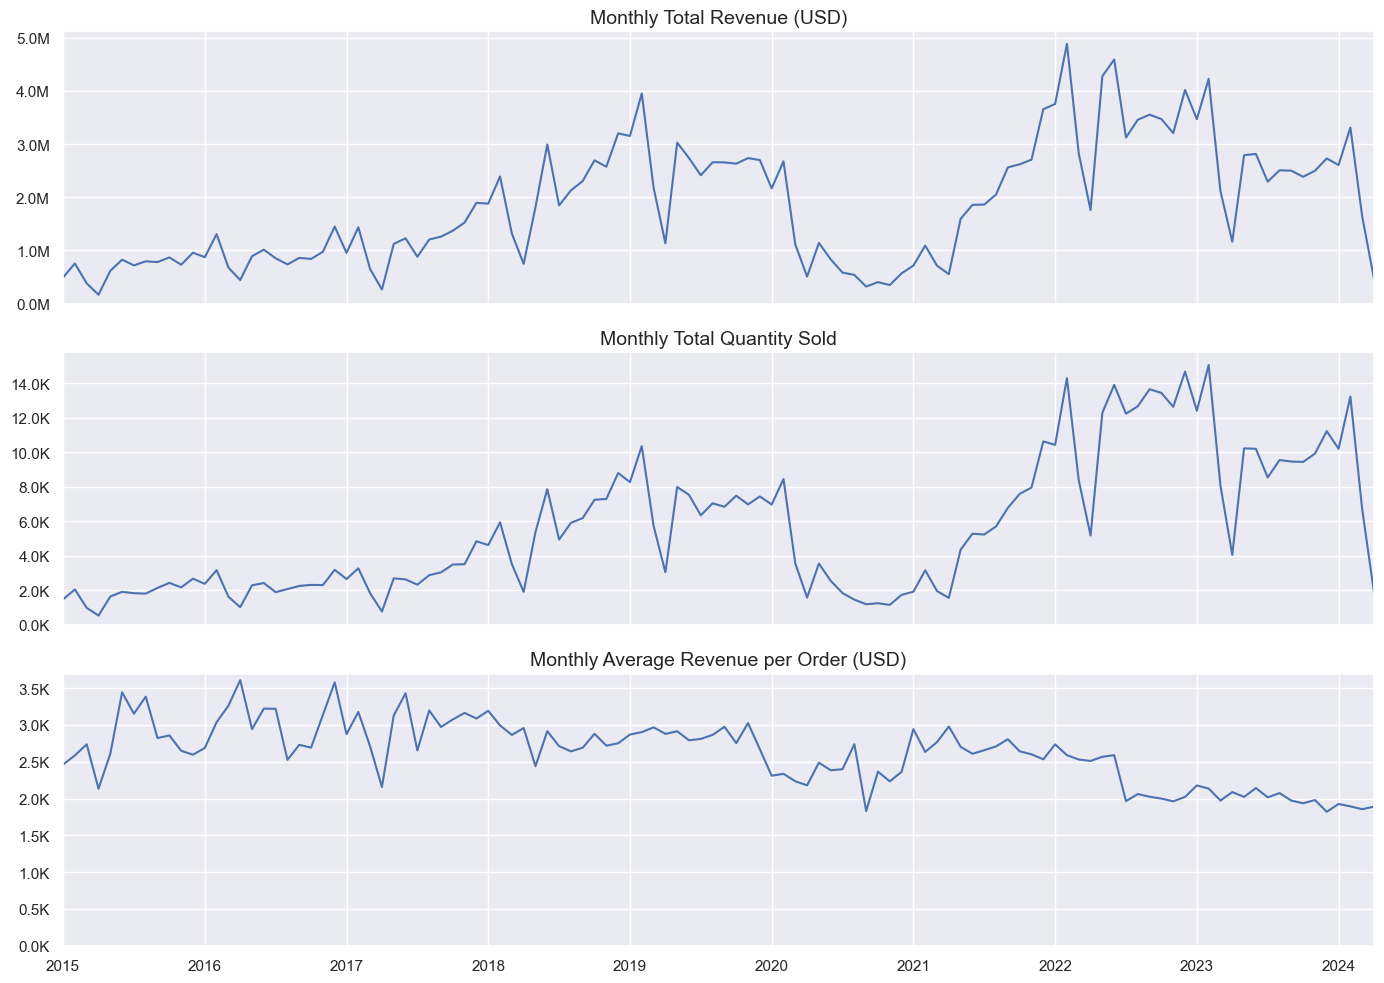

In [9]:
kpis_to_plot = ['total_rev', 'total_qty', 'avg_rev_per_order']
plot_titles = {
    'total_rev': 'Monthly Total Revenue (USD)',
    'total_qty': 'Monthly Total Quantity Sold',
    'avg_rev_per_order': 'Monthly Average Revenue per Order (USD)'
}

fig, ax = plt.subplots(len(kpis_to_plot), 1, figsize=(14, 10), sharex=True)

for i, kpi in enumerate(kpis_to_plot):
    df_plot = df_analysis[kpi]
    df_plot.plot(
        ax=ax[i],
        title=plot_titles.get(kpi, kpi)
    )
    ax[i].set_xlabel('')
    ax[i].set_ylim(bottom=0)

    if kpi == 'total_rev':
        ax[i].yaxis.set_major_formatter(FuncFormatter(millions_formatter))
    else:
        ax[i].yaxis.set_major_formatter(FuncFormatter(thousands_formatter))


fig.tight_layout()
plt.show()

##### Q1.2: Is there significant monthly seasonality in Total Revenue (USD)? Which months consistently show peak and off-peak performance across the years?

In [10]:
df_monthly_revenue = df_analysis[['total_rev']].copy()

df_seasonality = (
    df_monthly_revenue
    .groupby(df_analysis.index.month).median().round(2)
)

df_seasonality.index = [calendar.month_abbr[i] for i in df_seasonality.index]

df_seasonality

,total_rev
Jan,2023025.26
Feb,2533520.93
Mar,1214778.67
Apr,530832.69
May,1594090.93
Jun,1856606.58
Jul,1846384.25
Aug,2052547.07
Sep,2305241.13
Oct,2384326.12


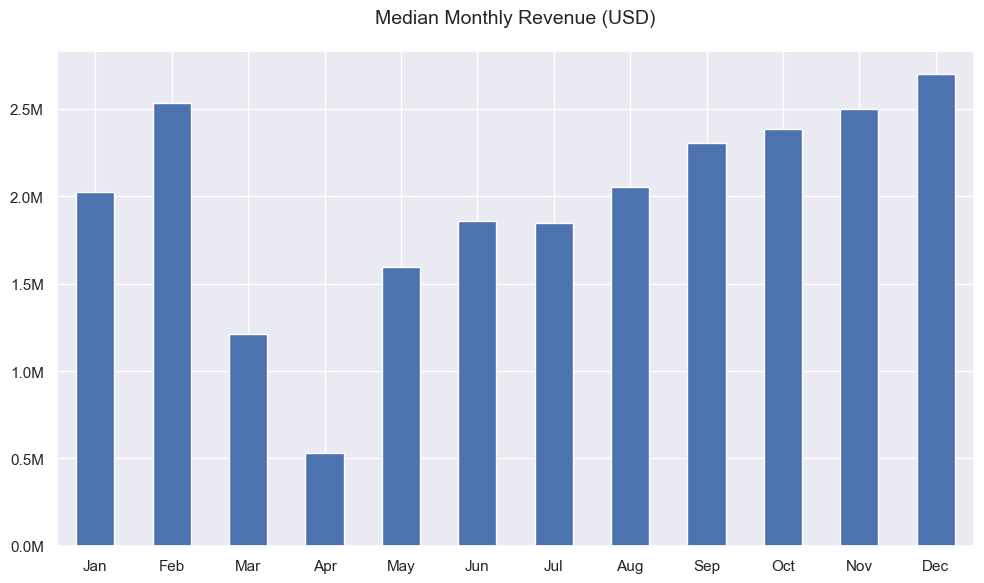

In [11]:
fig, ax = plt.subplots()

df_seasonality.plot(
    kind='bar',
    ax=ax,
    legend=False
)
ax.tick_params(axis='x', rotation=0)
ax.yaxis.set_major_formatter(FuncFormatter(millions_formatter))

plt.title('Median Monthly Revenue (USD)', pad=20)
plt.tight_layout()
plt.show()

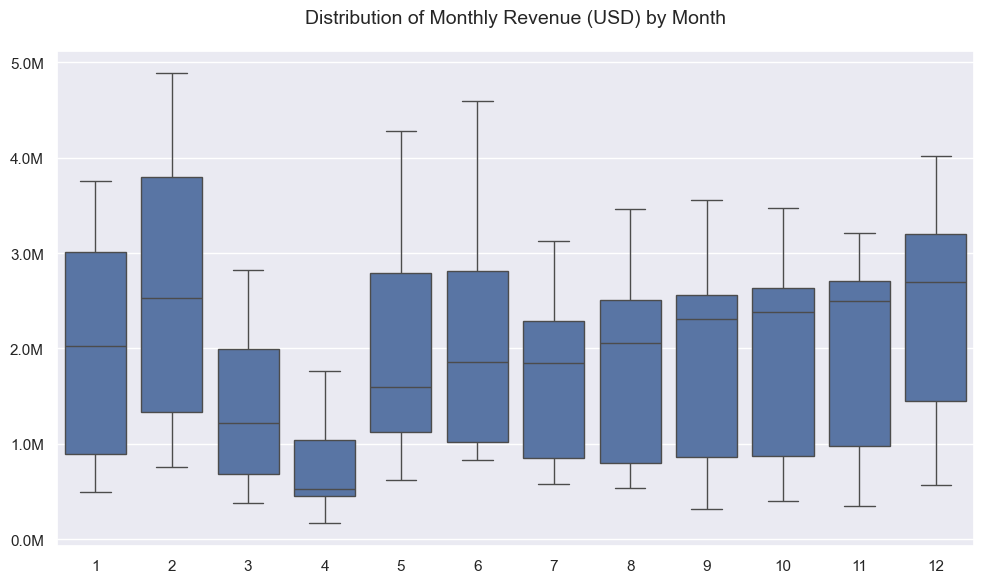

In [12]:
fig, ax = plt.subplots()
sns.boxplot(
    x=df_monthly_revenue.index.month,
    y=df_monthly_revenue['total_rev'],
    ax=ax
)
ax.set_title('Distribution of Monthly Revenue (USD) by Month', pad=20)
ax.set_xlabel('')
ax.set_ylabel('')
ax.yaxis.set_major_formatter(FuncFormatter(millions_formatter))

plt.tight_layout()
plt.show()

### Theme 2: Product Performance

##### Q2.1: Which product categories and sub-categories generate the most Revenue (USD) and Profit (USD)? What is their Profit Margin (%)?

In [13]:
df_subcat_analysis = (
    df[['productname', 'categoryname', 'subcategoryname', 'revenue_usd', 'profit_usd', 'quantity']]
    #.sample(5)
    .groupby(['categoryname', 'subcategoryname'])
    .agg(
        total_rev=('revenue_usd', 'sum'),
        total_profit=('profit_usd', 'sum')
    )
    .assign(
        profit_margin=lambda df_: (df_['total_profit'] / df_['total_rev']).replace(0, np.nan) * 100
    )
    .round(2)
    .sort_values(by='total_profit', ascending=False)
)

df_subcat_analysis.tail(5)

,,total_rev,total_profit,profit_margin
categoryname,subcategoryname,,,
Cell phones,Home & Office Phones,759467.06,406395.65,53.51
Home Appliances,Lamps,737300.26,400344.79,54.30
Cell phones,Cell phones Accessories,624301.35,350134.49,56.08
Games and Toys,Boxed Games,248424.98,132909.43,53.50
Home Appliances,Fans,232318.87,118351.85,50.94


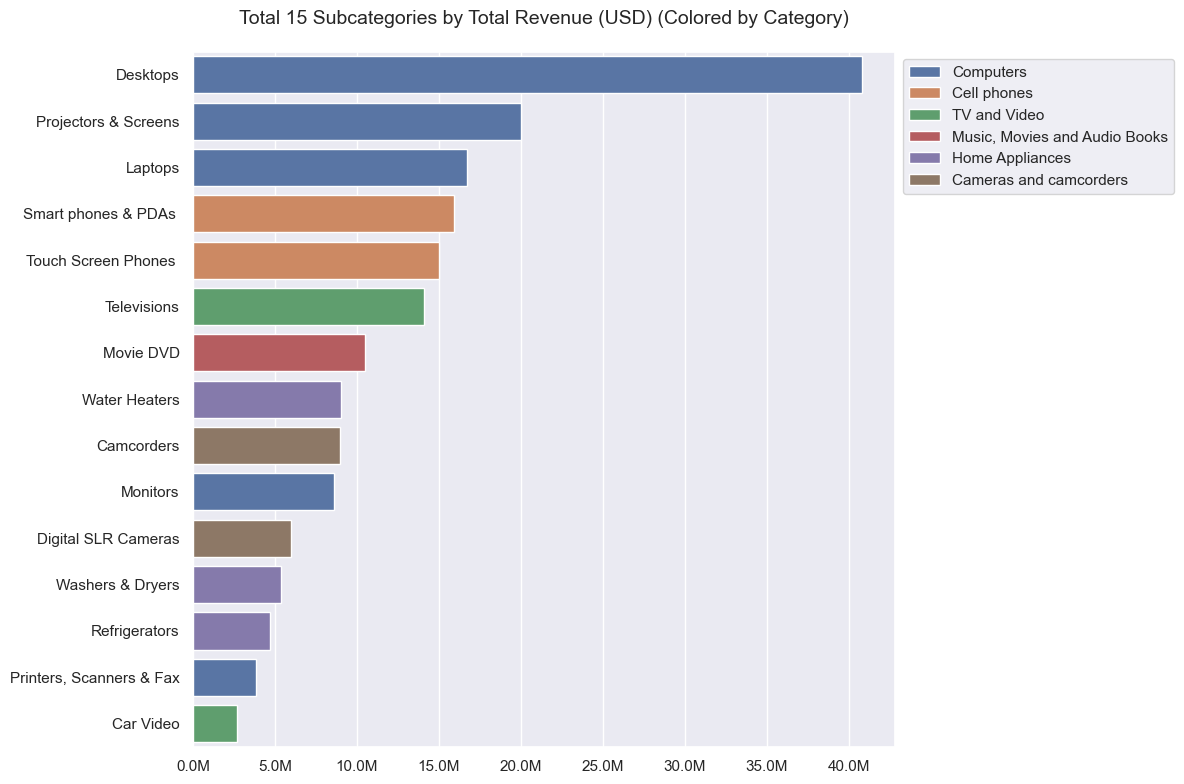

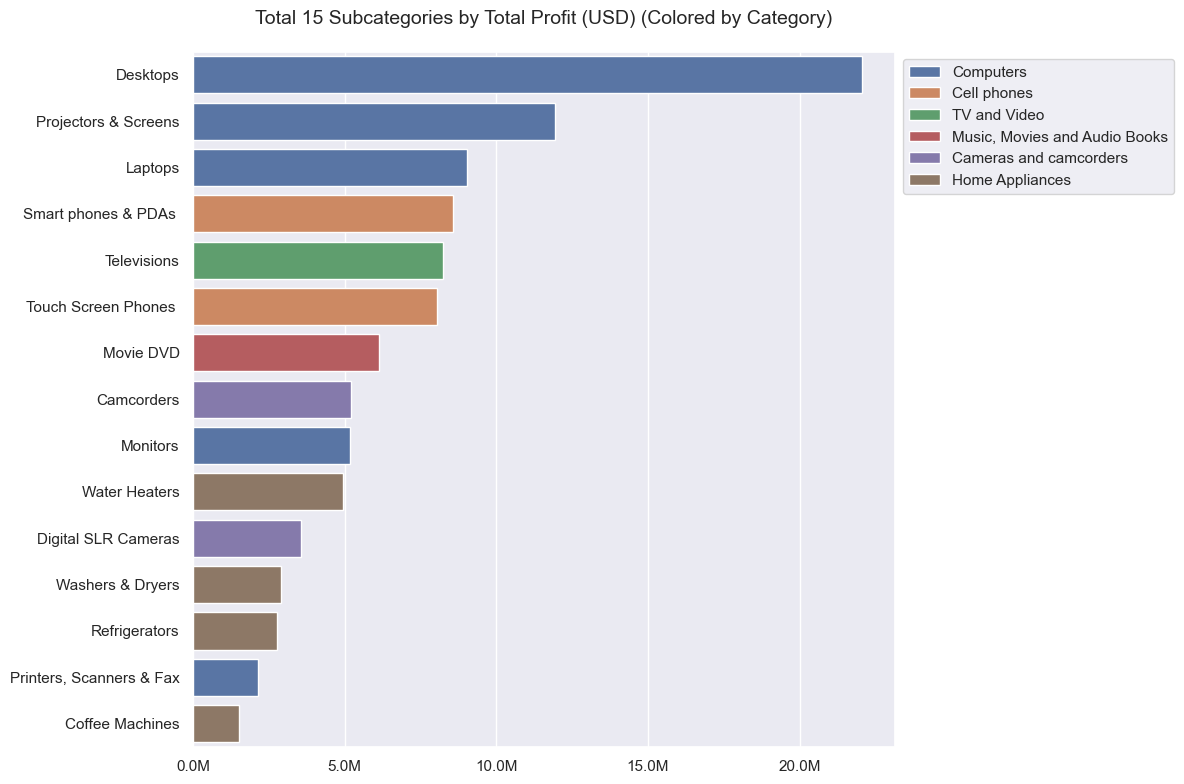

In [14]:
kpis_to_plot = ['total_rev', 'total_profit']
plot_titles = {
    'total_rev': 'Total 15 Subcategories by Total Revenue (USD)',
    'total_profit': 'Total 15 Subcategories by Total Profit (USD)',
}
df_plot = df_subcat_analysis.reset_index()

for kpi in kpis_to_plot:
    top_n = 15

    top_subcats_df = df_plot.nlargest(top_n, kpi)

    plt.figure(figsize=(12,8))
    
    sns.barplot(
        data=top_subcats_df,
        x=kpi,
        y='subcategoryname',
        hue='categoryname',
        dodge=False,
        orient='h',
        order=top_subcats_df.sort_values(kpi, ascending=False)['subcategoryname']
    )
    plt.title(f'{plot_titles.get(kpi, kpi)} (Colored by Category)', fontsize=14, pad=20)
    plt.xlabel('')
    plt.ylabel('')

    plt.gca().xaxis.set_major_formatter(FuncFormatter(millions_formatter))

    plt.legend(title='', bbox_to_anchor=(1, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

##### Q2.2 What are the characteristics of the top 10 most profitable products?

In [15]:
df_product_analysis = (
    df[['productname', 'revenue_usd', 'profit_usd', 'quantity', 'cost_usd']]
    .groupby('productname')
    .agg(
        total_qty=('quantity', 'sum'),
        total_rev=('revenue_usd', 'sum'),
        total_profit=('profit_usd', 'sum'),
        total_cost=('cost_usd', 'sum')
    )
    .assign(
        profit_margin=lambda df_: (df_['total_profit'] / df_['total_rev'].replace(0, np.nan) * 100),
        profit_pct_of_total=lambda df_: (df_['total_profit'] / df_['total_profit'].sum() * 100)
    )
    .round(2)
    .sort_values(by='total_profit', ascending=False)
)

top_10_products = df_product_analysis.head(10).copy()

top_10_products

,total_qty,total_rev,total_profit,total_cost,profit_margin,profit_pct_of_total
productname,,,,,,
WWI Desktop PC2.33 X2330 Silver,1390,1953212.73,1263121.66,690091.08,64.67,1.09
Adventure Works Desktop PC2.33 XD233 Black,1306,1901762.98,1234068.85,667694.12,64.89,1.07
Adventure Works Desktop PC2.33 XD233 White,1282,1866995.72,1208648.96,658346.76,64.74,1.05
Adventure Works Desktop PC2.33 XD233 Silver,1234,1785310.29,1156643.51,628666.78,64.79,1.00
Adventure Works Desktop PC2.33 XD233 Brown,1171,1767357.63,1148010.90,619346.73,64.96,0.99
WWI Desktop PC2.33 X2330 Brown,1296,1765305.59,1145473.74,619831.85,64.89,0.99
WWI Desktop PC2.33 X2330 White,1229,1717215.96,1110122.84,607093.12,64.65,0.96
WWI Desktop PC2.33 X2330 Black,1188,1665464.65,1080312.85,585151.79,64.87,0.94
"Adventure Works 52"" LCD HDTV X590 White",465,1187678.09,767702.67,419975.42,64.64,0.67


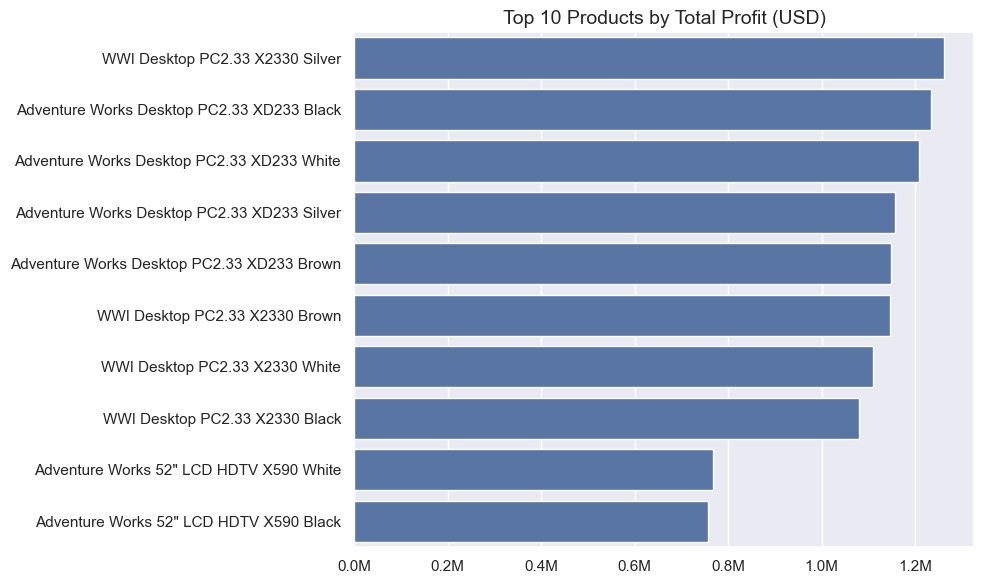

In [16]:
sns.barplot(
    data=top_10_products.reset_index(),
    y='productname',
    x='total_profit',
    orient='h'
)

plt.title('Top 10 Products by Total Profit (USD)')
plt.xlabel('')
plt.ylabel('')
plt.gca().xaxis.set_major_formatter(FuncFormatter(millions_formatter))
plt.tight_layout()
plt.show()

##### Q2.3 Which product was the single biggest contributor to profit each year, and what percentage of that year's profit did it represent?

In [17]:
df_product_yearly = (
    df.loc['2015':'2023', ['productname', 'profit_usd']]
    .assign(year=lambda df_: df_.index.year)
    .groupby(['year', 'productname'])
    .agg(total_profit=('profit_usd', 'sum'))
    .pipe(
        lambda df_: df_.assign(
            total_yearly_profit=df_.groupby(level='year')['total_profit'].transform('sum')
        )
    )
    .pipe(
        lambda df_: df_.assign(
            profit_pct_of_year=df_['total_profit'] / df_['total_yearly_profit'].replace(0, np.nan) * 100
        )
    )  
)

top_product_per_year = (
    df_product_yearly
    .sort_values(by=['year', 'total_profit'], ascending=[True, False])
    .groupby(level='year')
    .head(1)
    .round(2)
)

top_product_per_year

,,total_profit,total_yearly_profit,profit_pct_of_year
year,productname,,,
2015,WWI Desktop PC2.33 X2330 Silver,51636.68,4545092.39,1.14
2016,Adventure Works Desktop PC2.33 XD233 White,113589.41,6104797.18,1.86
2017,Adventure Works Desktop PC2.33 XD233 White,128556.86,7715204.25,1.67
2018,Adventure Works Desktop PC2.33 XD233 Brown,197370.28,14446597.38,1.37
2019,Adventure Works Desktop PC2.33 XD233 Black,307948.80,17865935.55,1.72
2020,Adventure Works Desktop PC2.33 XD233 Black,88772.83,6263569.46,1.42
2021,WWI Desktop PC2.33 X2330 Silver,203089.68,12319522.82,1.65
2022,"Adventure Works 52"" LCD HDTV X590 Black",247840.53,23960266.47,1.03
2023,"Adventure Works 52"" LCD HDTV X590 White",208579.20,17666865.54,1.18


In [18]:
top_10_contribution = (
    df_product_yearly
    .sort_values(by=['year', 'total_profit'], ascending=[True, False])
    .groupby(level='year')
    .head(10)
    .groupby(level='year')[['total_profit', 'profit_pct_of_year']]
    .sum()
    .round(2)
)

top_10_contribution

,total_profit,profit_pct_of_year
year,,
2015,418304.51,9.20
2016,665877.93,10.91
2017,954065.06,12.37
2018,1659422.20,11.49
2019,2293223.26,12.84
2020,740084.68,11.82
2021,1408609.98,11.43
2022,2040450.46,8.52
2023,1278007.18,7.23


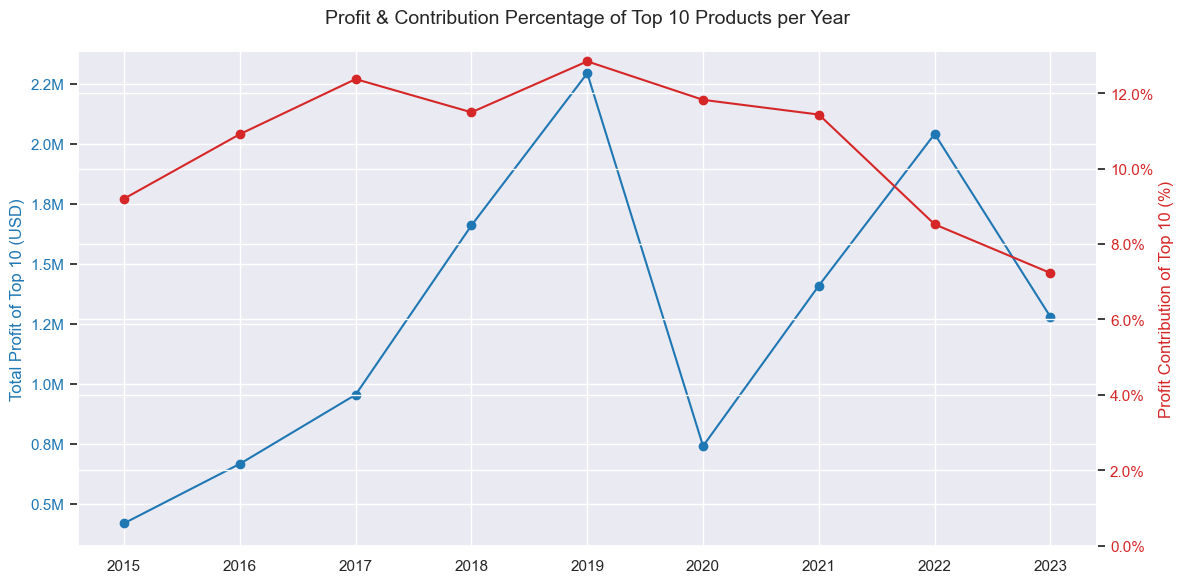

In [19]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel('')
color1= 'tab:blue'
ax1.set_ylabel('Total Profit of Top 10 (USD)', color=color1)

line1 = ax1.plot(
    top_10_contribution.index,
    top_10_contribution['total_profit'],
    color=color1,
    marker='o',
    linestyle='-',
    label='Top 10 Profit (USD)'
)

ax1.tick_params(axis='y', labelcolor=color1)
ax1.yaxis.set_major_formatter(FuncFormatter(millions_formatter))

# Create Secondary Axis
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Profit Contribution of Top 10 (%)', color=color2)

line2 = ax2.plot(
    top_10_contribution.index,
    top_10_contribution['profit_pct_of_year'],
    color=color2,
    marker='o',
    linestyle='-',
    label='Top 10 Contribution (%)'
)

ax2.tick_params(axis='y', labelcolor=color2)
ax2.yaxis.set_major_formatter(PercentFormatter(xmax=100))
ax2.set_ylim(bottom=0)

plt.title('Profit & Contribution Percentage of Top 10 Products per Year', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

### Theme 3 : Customer Insights

##### Q3.1 What is the distribution of customers by key demographics (e.g., Gender, Age Group, Location/City) and how does their total spending (Revenue USD) compare across these segments?

In [20]:
df[['customerkey', 'gender', 'age', 'countryfull', 'statefull', 'revenue_usd']].isnull().sum()

customerkey    0
gender         0
age            0
countryfull    0
statefull      0
revenue_usd    0
dtype: int64

In [21]:
bins = [15, 25, 35, 45, 55, 65, 100]

df_customer = (
    df[['customerkey', 'gender', 'age', 'countryfull', 'statefull', 'revenue_usd']]
    .assign(age_group=pd.cut(df['age'], bins=bins))
)

df_customer.sample(5)

,customerkey,gender,age,countryfull,statefull,revenue_usd,age_group
orderdate,,,,,,,
2021-05-26,449530,female,42,Germany,Freistaat Bayern,18.315067,"(35, 45]"
2019-06-18,1389010,male,71,United States,North Carolina,14.472000,"(65, 100]"
2023-05-24,1866049,male,73,United States,Florida,1806.700000,"(65, 100]"
2017-01-19,994946,female,61,United Kingdom,Lewes,1816.528009,"(55, 65]"
2016-02-11,853685,female,33,Netherlands,Noord-Holland,524.183867,"(25, 35]"


In [22]:
(
    df_customer
    [['customerkey', 'gender']]
    .drop_duplicates(subset=['customerkey'])
    .set_index('customerkey')
    .value_counts(normalize=True)
    #.plot(kind='bar')
)

gender
male      0.504537
female    0.495463
Name: proportion, dtype: float64

In [23]:
(
    df_customer
    [['customerkey', 'age_group']]
    .drop_duplicates(subset=['customerkey'])
    .set_index('customerkey')
    .value_counts(normalize=True)
    .sort_index()
    #.plot(kind='bar')
)

age_group
(15, 25]     0.105321
(25, 35]     0.152343
(35, 45]     0.147998
(45, 55]     0.150747
(55, 65]     0.149150
(65, 100]    0.294441
Name: proportion, dtype: float64

In [24]:
(
    df_customer
    [['customerkey', 'countryfull']]
    .drop_duplicates(subset=['customerkey'])
    .set_index('customerkey')
    .value_counts(normalize=True)
    #.plot(kind='bar')
)

countryfull   
United States     0.487704
United Kingdom    0.117991
Canada            0.103219
Germany           0.102633
Australia         0.072059
Netherlands       0.044598
France            0.036838
Italy             0.034959
Name: proportion, dtype: float64

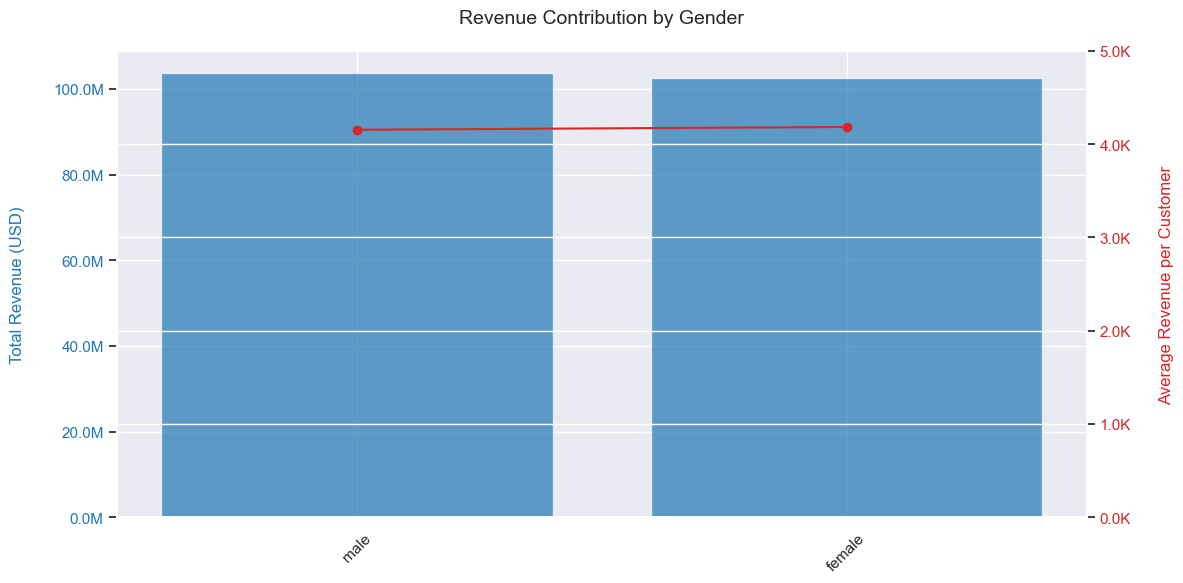

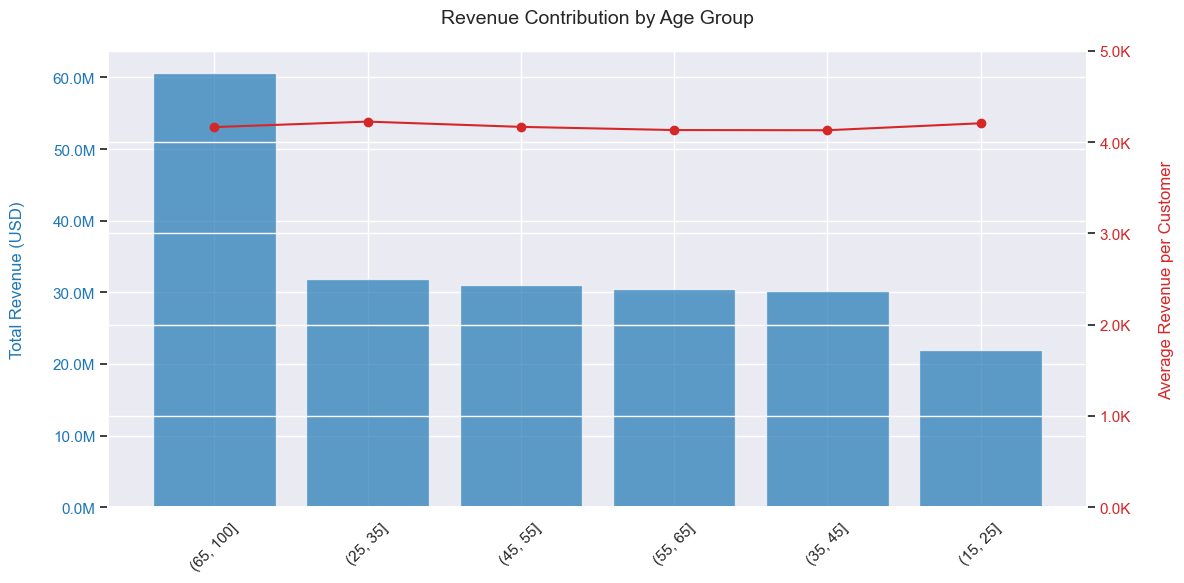

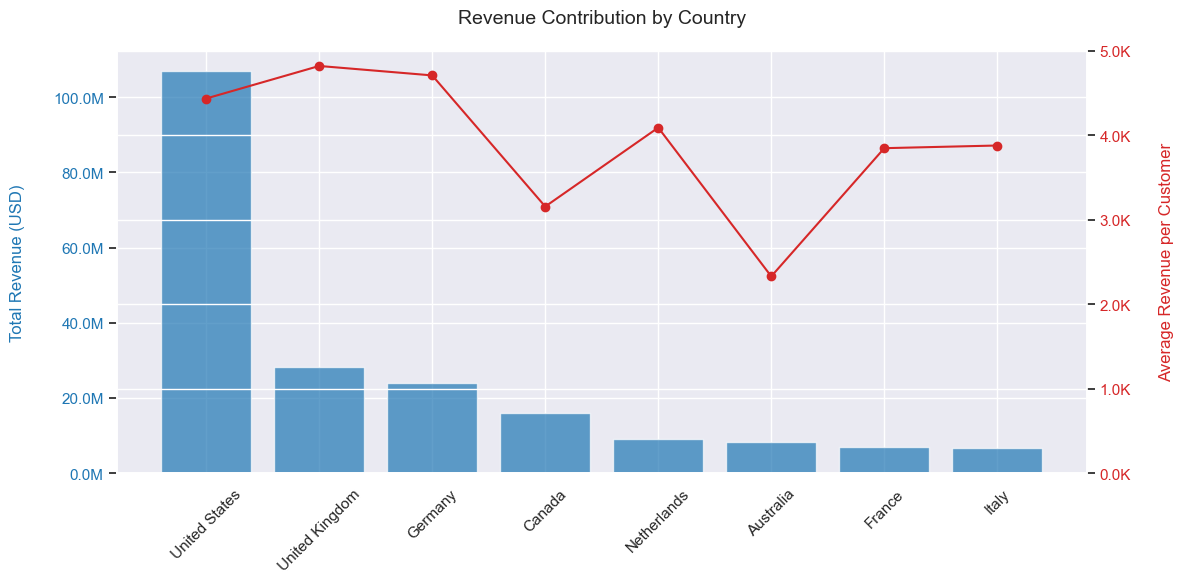

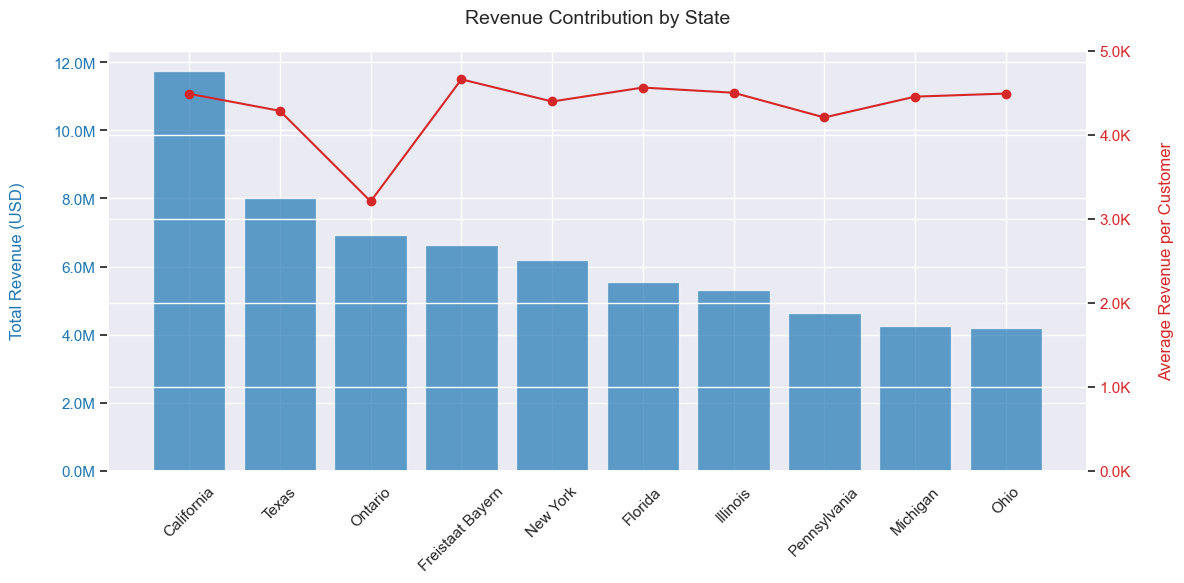

In [25]:
segments = ['gender', 'age_group', 'countryfull', 'statefull']
plot_titles = {
    'gender': 'Revenue Contribution by Gender',
    'age_group': 'Revenue Contribution by Age Group',
    'countryfull': 'Revenue Contribution by Country',
    'statefull': 'Revenue Contribution by State',
}

for segment in segments:
    df_customer_segment = (
        df_customer
        .groupby(segment, observed=True)
        .agg(
            total_revenue=('revenue_usd', 'sum'),
            unique_customers=('customerkey', 'nunique')
        )
        .assign(
                avg_rev_per_cus=lambda df_: df_['total_revenue'] / df_['unique_customers'].replace(0, np.nan)
        )
        .sort_values(by='total_revenue', ascending=False)
    )

    # Handle too many categories (e.g., States / Cities)
    data_to_plot = df_customer_segment
    plot_title = plot_titles.get(segment, f'Revenue Contribution by {segment}') 

    top_n = 10
    if len(df_customer_segment) > top_n:
        data_to_plot = df_customer_segment.head(top_n)

    fig, ax1 = plt.subplots(figsize=(12, 6))

    color1= 'tab:blue'
    ax1.set_xlabel('')
    ax1.set_ylabel('Total Revenue (USD)', color=color1, labelpad=20)

    bars = ax1.bar(
        data_to_plot.index.astype(str), 
        data_to_plot['total_revenue'], 
        color=color1, 
        alpha=0.7, 
        label='Total Revenue (USD)'
    )

    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.yaxis.set_major_formatter(FuncFormatter(millions_formatter))
    ax1.tick_params(axis='x', rotation=45)

    # Create Secondary Axis
    ax2 = ax1.twinx()
    color2 = 'tab:red'
    ax2.set_ylabel('Average Revenue per Customer', color=color2, labelpad=20)

    line = ax2.plot(
        data_to_plot.index.astype(str), 
        data_to_plot['avg_rev_per_cus'], 
        color=color2, 
        marker='o', 
        linestyle='-', 
        label='Avg Revenue/Customer (USD)'
    )

    ax2.tick_params(axis='y', labelcolor=color2)
    ax2.yaxis.set_major_formatter(FuncFormatter(thousands_formatter))
    ax2.set_ylim(0, 5000)

    plt.title(plot_title, fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()

##### Q3.2: Can we segment customers using RFM (Recency, Frequency, Monetary) analysis based on their USD spending? What are the characteristics of the highest value segments?

- Customers who bought recently are more likely to buy again soon than those who haven't bought in years. (Recency)
- Customers who buy frequently are more likely to be loyal and engaged than one-time buyers. (Frequency)
- Customers who have spent more in the past might be more valuable overall (though high spend doesn't always equal high profit). (Monetary)

---

- High R, F, M ("Champions"): These are your best customers. 
    - Business Action: Offer loyalty rewards, ask for reviews, give early access to new products, nurture the relationship. Don't bombard them with generic discounts they don't need.
- Low R, High F, M ("At Risk" / "Cannot Lose Them"): They used to buy often and spend well, but haven't recently. 
    - Business Action: Target them with personalized "We miss you!" campaigns, special offers, or surveys to find out why they stopped buying. High priority for retention efforts.
- High R, Low F, M ("New Customers"): They just made their first purchase. 
    - Business Action: Send welcome emails, provide onboarding help, suggest related products to encourage a second purchase.
- Low F, Low M (various R): These might be "Lost" customers (if R is also low) or just occasional, low-value buyers. 
    - Business Action: May deserve minimal marketing spend, perhaps exclude from general campaigns. Focus on acquiring better customers.
- High F, High R, Medium M ("Loyalists"): Consistent buyers. 
    - Business Action: Engage them with content, introduce new relevant products (cross-sell/upsell), offer membership benefits.

In [26]:
snapshot_date = df.index.max() + pd.Timedelta(days=1)

In [27]:
rfm_df = (
    df
    .reset_index()
    .groupby('customerkey')
    .agg(
        LastPurchaseDate=('orderdate', 'max'),
        Frequency=('orderkey', pd.Series.nunique),
        Monetary=('revenue_usd', 'sum')
    )
    .assign(
        Recency=(lambda df_: (snapshot_date - df_['LastPurchaseDate']).dt.days)
    )
    .loc[:,['Recency', 'Frequency', 'Monetary']]
)

In [28]:
rfm_df.head()

,Recency,Frequency,Monetary
customerkey,,,
15,1140,1,1299.708307
180,237,2,1103.346104
185,1786,1,666.453820
243,2894,1,148.903542
387,157,3,2341.268364


In [29]:
rfm_df.describe()

,Recency,Frequency,Monetary
count,49487.000000,49487.000000,49487.000000
mean,990.932952,1.679835,4168.228958
std,833.792272,0.946187,5137.650904
min,1.000000,1.000000,1.878033
25%,340.000000,1.000000,836.780440
50%,681.000000,1.000000,2445.504933
75%,1641.500000,2.000000,5575.706057
max,3398.000000,10.000000,68447.861791


Interpret RFM Describe Result
- Recency (R):
The mean recency is very high (~991 days, or over 2.5 years!), and the median (50%) is also high (~681 days, almost 2 years). This means a large portion of your customer base hasn't purchased in a very long time.
The min is 1 day, so you do have recent activity, but the 75% value (1641 days, ~4.5 years) confirms that only 25% of your customers have purchased within the last ~11 months (340 days).
Insight: Suggests potential challenges with customer retention or a high number of inactive customers.
---
- Frequency (F):
This is striking. The mean frequency is only ~1.68 purchases, and the median (50%) is just 1!
The 75th percentile (75%) is only 2.
Insight: This indicates that a very large proportion (at least half, likely more) of your customers have only ever made one purchase. Repeat business seems quite low, with even the most frequent customer making only 10 purchases over the dataset's span.
---
- Monetary (M):
The mean ($4168) is significantly higher than the median (50%, $2445). This, along with a high standard deviation ($5137), suggests the distribution is right-skewed.
Insight: While the average total spend is decent, it's likely driven by a smaller number of customers who spend significantly more than the typical customer. The majority spend relatively modest amounts in total.
---
- Overall Preliminary Insights: Your customer base seems heavily weighted towards infrequent, potentially one-time buyers, many of whom haven't purchased in a long time. Revenue appears concentrated among a smaller group of higher spenders or more frequent buyers (though even max frequency is low).

In [30]:
# Define labels for scoring
# Reversed for Recency (lower days = higher score)
r_labels = [5, 4, 3, 2, 1]
# Standard for Frequency/Monetary (higher value = higher score)
fm_labels = [1, 2, 3, 4, 5]
fm_labels = [1, 2, 3, 4, 5]

# Calculate R Score (Quintiles - 5 groups)
rfm_df['R_Score'] = pd.qcut(rfm_df['Recency'], q=5, labels=r_labels, duplicates='drop')

# Calculate F Score (Quintiles - 5 groups)
# Use rank(method='first') to handle ties, then qcut on ranks
rfm_df['F_Score'] = pd.qcut(rfm_df['Frequency'].rank(method='first'), q=5, labels=fm_labels, duplicates='drop')
    
# Calculate M Score (Quintiles - 5 groups)
rfm_df['M_Score'] = pd.qcut(rfm_df['Monetary'], q=5, labels=fm_labels, duplicates='drop')

# --- Convert scores to numeric type (qcut might return categorical) ---
rfm_df['R_Score'] = pd.to_numeric(rfm_df['R_Score'])
rfm_df['F_Score'] = pd.to_numeric(rfm_df['F_Score'])
rfm_df['M_Score'] = pd.to_numeric(rfm_df['M_Score'])

# --- Create Combined Score/Segment ---
# String representation (e.g., '545')
rfm_df['RFM_Segment_Str'] = rfm_df['R_Score'].astype(str) + rfm_df['F_Score'].astype(str) + rfm_df['M_Score'].astype(str)

# Simple Sum Score (less granular but useful sometimes)
rfm_df['RFM_Score_Sum'] = rfm_df['R_Score'] + rfm_df['F_Score'] + rfm_df['M_Score']

rfm_df

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment_Str,RFM_Score_Sum
customerkey,,,,,,,,
15,1140,1,1299.708307,2,1,2,212,5
180,237,2,1103.346104,5,3,2,532,10
185,1786,1,666.453820,2,1,2,212,5
243,2894,1,148.903542,1,1,1,111,3
387,157,3,2341.268364,5,5,3,553,13
...,...,...,...,...,...,...,...,...
2099619,1381,4,6709.935970,2,5,5,255,12
2099656,75,4,10404.677800,5,5,5,555,15
2099697,586,1,38.201100,3,3,1,331,7


In [31]:
import re

def assign_segment(row):
    """Assigns segment name based on RFM_Segment_Str pattern"""
    rfm_str = str(row['RFM_Segment_Str']) # Ensure it's a string

    # Order matters: Check most valuable / specific first
    if re.match(r'5[4-5][4-5]', rfm_str): return 'Champions'
    if re.match(r'[3-4][4-5][3-5]', rfm_str): return 'Loyal Customers'
    # Active med-value customers
    if re.match(r'[4-5][4-5][2-3]', rfm_str): return 'Active Loyalists - Med Value'
    if re.match(r'[1-2][3-5][3-5]', rfm_str): return 'At Risk'
    # Potential Loyalists - Recent, but lower Freq/Spend
    if re.match(r'[4-5][1-3].', rfm_str): return 'Potential Loyalists' # Catches recent low F/M
    # Add segment for Low R, Avg F, Low M
    if re.match(r'[1-2]3[1-2]', rfm_str): return 'Slipping - Low Value'
    # Add segment for Avg R, Low F
    if re.match(r'3[1-2].', rfm_str): return 'Infrequent - Mid Recency'
    # Specific Need Attention group (Avg R/F/M)
    if re.match(r'333', rfm_str): return 'Need Attention'
    # Add segment for Avg R/F but Low M
    if re.match(r'33[1-2]', rfm_str): return 'Need Attention - Low Value'
     # Hibernating/Lost - Low R, Low F
    if re.match(r'[1-2][1-2].', rfm_str): return 'Hibernating/Lost'

    # Catch-all for unclassified
    return 'Other - Unclassified'

# Apply the function to create the 'Segment' column
rfm_df['Segment'] = rfm_df.apply(assign_segment, axis=1)

rfm_df

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment_Str,RFM_Score_Sum,Segment
customerkey,,,,,,,,,
15,1140,1,1299.708307,2,1,2,212,5,Hibernating/Lost
180,237,2,1103.346104,5,3,2,532,10,Potential Loyalists
185,1786,1,666.453820,2,1,2,212,5,Hibernating/Lost
243,2894,1,148.903542,1,1,1,111,3,Hibernating/Lost
387,157,3,2341.268364,5,5,3,553,13,Active Loyalists - Med Value
...,...,...,...,...,...,...,...,...,...
2099619,1381,4,6709.935970,2,5,5,255,12,At Risk
2099656,75,4,10404.677800,5,5,5,555,15,Champions
2099697,586,1,38.201100,3,3,1,331,7,Need Attention - Low Value


In [32]:
# --- Analyze Segment Distribution ---
segment_counts = rfm_df['Segment'].value_counts().reset_index()
segment_counts.columns = ['Segment', 'Count']
segment_counts['Percentage'] = (segment_counts['Count'] / segment_counts['Count'].sum() * 100).round(1)

segment_counts

,Segment,Count,Percentage
0,Hibernating/Lost,10659,21.5
1,Potential Loyalists,8787,17.8
2,Loyal Customers,8102,16.4
3,At Risk,5779,11.7
4,Champions,3740,7.6
5,Infrequent - Mid Recency,3566,7.2
6,Slipping - Low Value,2552,5.2
7,Active Loyalists - Med Value,2463,5.0
8,Other - Unclassified,2420,4.9
9,Need Attention - Low Value,957,1.9


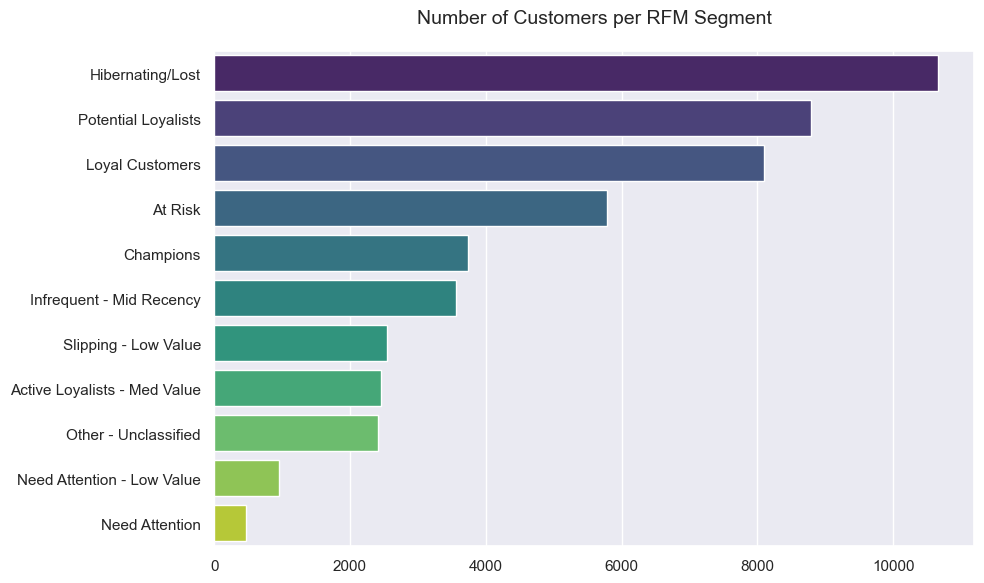

In [33]:
# --- Analyze Segment Characteristics (Average RFM) ---
segment_characteristics = (
    rfm_df.groupby('Segment')[['Recency', 'Frequency', 'Monetary']]
    .mean()
    .round(1)
)

# Add the count to the characteristics table
segment_characteristics = segment_characteristics.join(segment_counts.set_index('Segment')['Count'])

# --- Visualize Segment Sizes ---
plt.figure(figsize=(10, 6))
sns.barplot(
    data=segment_counts.sort_values('Count', ascending=False), 
    x='Count', 
    y='Segment',
    palette='viridis',
    hue='Segment'
)
plt.title('Number of Customers per RFM Segment', pad=20)
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
plt.show()

### Theme 4: Store & Regional Performance

Q4.1: How does Total Revenue (USD) and Total Profit (USD) compare across different Stores and Cities?

In [34]:
df_store = (
    df[df['storekey'] != 999999]
    .loc[:, ['state_store', 'countryname', 'revenue_usd', 'profit_usd']]
    .map(lambda s: s.title() if type(s) == str else s)
    .rename(columns={
        'countryname': 'country_store'
    })
)

In [35]:
(
    df_store
    .drop_duplicates(['state_store', 'country_store'])
    .reset_index()
    [['state_store', 'country_store']]
    .groupby('country_store')
    .size()
    .sort_values(ascending=False)
)

country_store
United States     24
Germany            9
France             7
United Kingdom     7
Australia          6
Canada             5
Netherlands        5
Italy              3
dtype: int64

In [36]:
df_store_US_analysis = (
    df_store
    .loc[df_store['country_store'] == 'United States', :]
    .groupby(['state_store'])
    .agg(
        total_revenue=('revenue_usd', 'sum'),
        total_profit=('profit_usd', 'sum')
    )
)

df_store_US_analysis.head(8)

,total_revenue,total_profit
state_store,,
Alaska,2.826503e+06,1.579441e+06
Arkansas,3.368625e+06,1.876726e+06
Connecticut,3.287155e+06,1.841680e+06
Delaware,1.277979e+06,7.089259e+05
Hawaii,2.640226e+06,1.459113e+06
Idaho,3.046408e+06,1.706578e+06
Iowa,2.422122e+06,1.349262e+06
Kansas,3.572385e+06,2.009324e+06


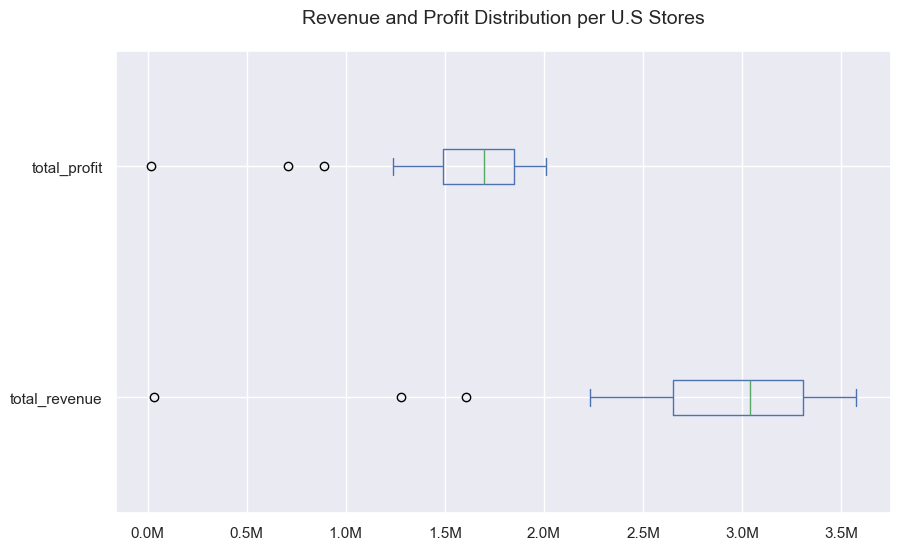

In [37]:
df_store_US_analysis.plot(kind='box', vert=False)
plt.gca().xaxis.set_major_formatter(FuncFormatter(millions_formatter))
plt.title('Revenue and Profit Distribution per U.S Stores', pad=20)
plt.show()

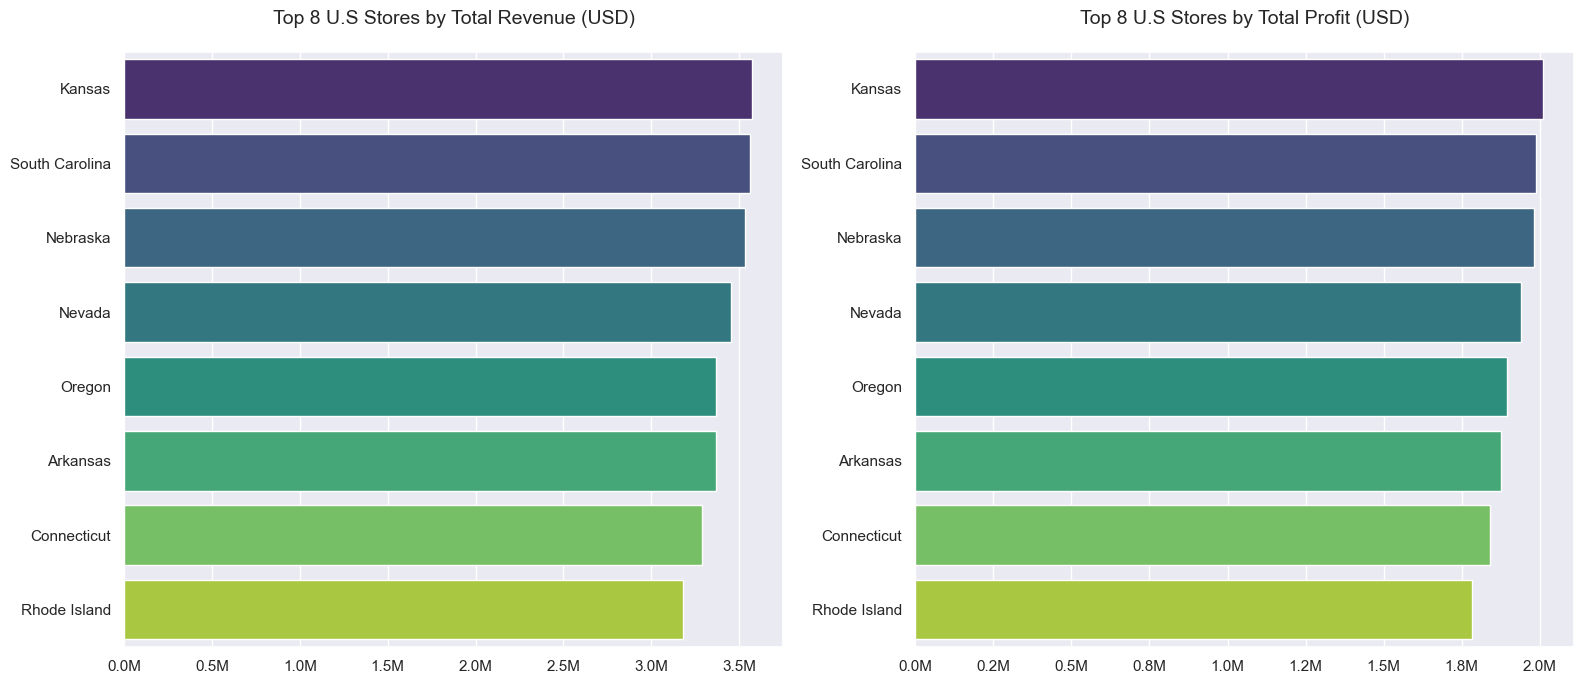

In [38]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,7))

sns.barplot(
    data=df_store_US_analysis.reset_index().sort_values(by='total_revenue', ascending=False).head(8),
    x='total_revenue',
    y='state_store',
    ax=ax1,
    palette='viridis',
    hue='state_store'
)
ax1.xaxis.set_major_formatter(FuncFormatter(millions_formatter))
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_title('Top 8 U.S Stores by Total Revenue (USD)', pad=20)

sns.barplot(
    data=df_store_US_analysis.reset_index().sort_values(by='total_profit', ascending=False).head(8),
    x='total_profit',
    y='state_store',
    ax=ax2,
    palette='viridis',
    hue='state_store'
)
ax2.xaxis.set_major_formatter(FuncFormatter(millions_formatter))
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_title('Top 8 U.S Stores by Total Profit (USD)', pad=20)

plt.tight_layout()
plt.show()

In [39]:
df_store_excl_US_analysis = (
    df_store
    .loc[df_store['country_store'] != 'United States', :]
    .groupby(['state_store', 'country_store'])
    .agg(
        total_revenue=('revenue_usd', 'sum'),
        total_profit=('profit_usd', 'sum')
    )
)

df_store_excl_US_analysis.head()

,,total_revenue,total_profit
state_store,country_store,,
Armagh,United Kingdom,2.905007e+06,1.598590e+06
Australian Capital Territory,Australia,5.645060e+05,3.182202e+05
Ayrshire,United Kingdom,2.944536e+06,1.656038e+06
Basse-Normandie,France,5.376177e+05,2.992336e+05
Belfast,United Kingdom,2.805257e+06,1.552847e+06


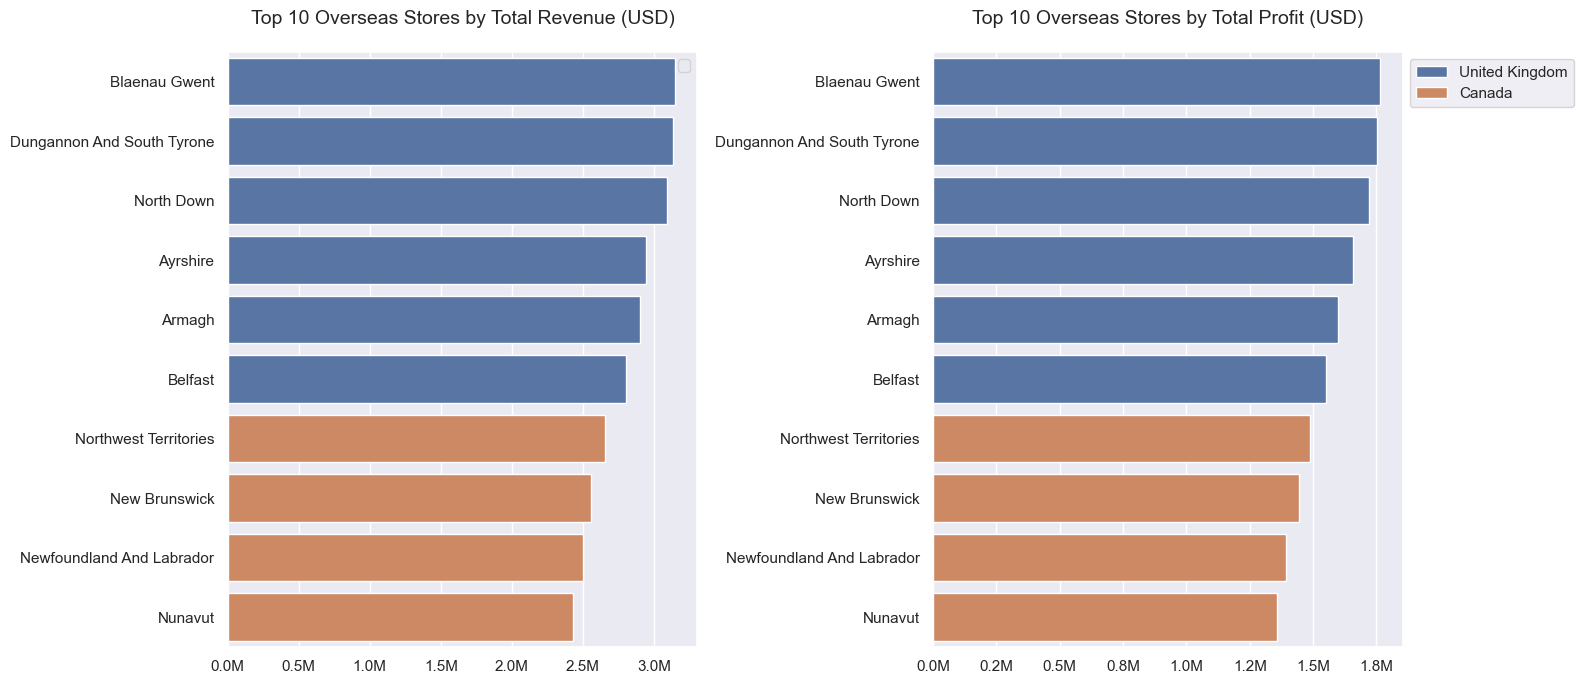

In [40]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,7))

sns.barplot(
    data=df_store_excl_US_analysis.reset_index().sort_values(by='total_revenue', ascending=False).head(10),
    x='total_revenue',
    y='state_store',
    hue='country_store',
    ax=ax1
)
ax1.xaxis.set_major_formatter(FuncFormatter(millions_formatter))
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_title('Top 10 Overseas Stores by Total Revenue (USD)', pad=20)
ax1.legend('')

sns.barplot(
    data=df_store_excl_US_analysis.reset_index().sort_values(by='total_profit', ascending=False).head(10),
    x='total_profit',
    y='state_store',
    hue='country_store',
    ax=ax2
)
ax2.xaxis.set_major_formatter(FuncFormatter(millions_formatter))
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_title('Top 10 Overseas Stores by Total Profit (USD)', pad=20)
ax2.legend(title='', bbox_to_anchor=(1, 1), loc='upper left')

plt.tight_layout()
plt.show()

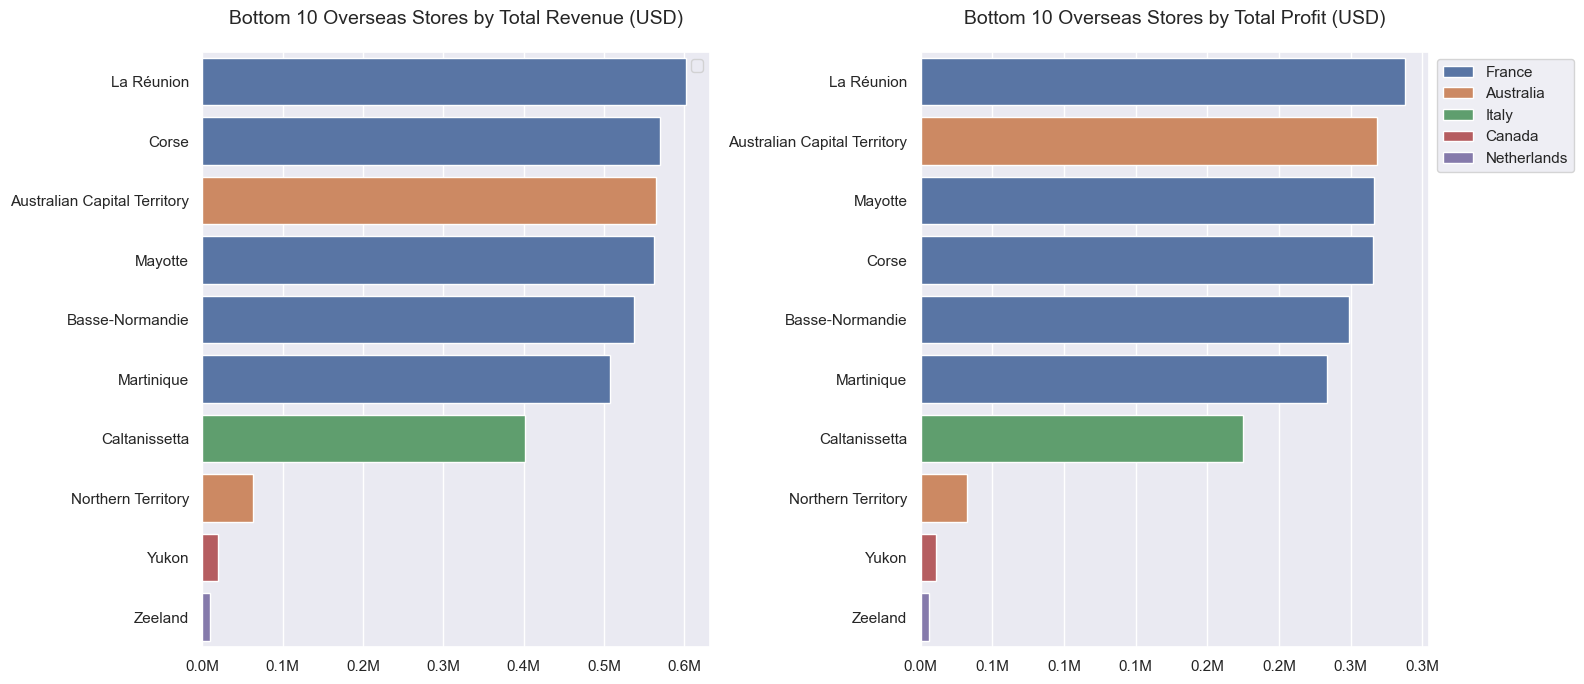

In [41]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,7))

sns.barplot(
    data=df_store_excl_US_analysis.reset_index().sort_values(by='total_revenue', ascending=False).tail(10),
    x='total_revenue',
    y='state_store',
    hue='country_store',
    ax=ax1
)
ax1.xaxis.set_major_formatter(FuncFormatter(millions_formatter))
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_title('Bottom 10 Overseas Stores by Total Revenue (USD)', pad=20)
ax1.legend('')

sns.barplot(
    data=df_store_excl_US_analysis.reset_index().sort_values(by='total_profit', ascending=False).tail(10),
    x='total_profit',
    y='state_store',
    hue='country_store',
    ax=ax2
)
ax2.xaxis.set_major_formatter(FuncFormatter(millions_formatter))
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_title('Bottom 10 Overseas Stores by Total Profit (USD)', pad=20)
ax2.legend(title='', bbox_to_anchor=(1, 1), loc='upper left')

plt.tight_layout()
plt.show()